In [316]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta
import glob, os
import warnings
warnings.filterwarnings("ignore")

In [331]:
class Strategy:
    def find_signals(self, orderbook, strategy_func):

        signals, stats = strategy_func(orderbook)
                
        return signals, stats
    
           
class DataLoader:
    def __init__(self, filepath_list, dates_list, preprocess_func=None):
        self.dates_list = dates_list
        self.filepath_list = filepath_list
        if preprocess_func is not None:
            self.preprocess_func = preprocess_func
        else:
            self.preprocess_func  = None
        
    def get_data(self):
        for filepath, date in zip(self.filepath_list, self.dates_list):
            df = pd.read_csv(filepath)
            if self.preprocess_func is not None:
                yield self.preprocess_func(df), date
            else:
                yield df, date
            
    
def transform_my_order_data(data_df):
    cols = ['Time'] + sum([['BID_PRICE' + str(i),  'BID_SIZE' + str(i), 'ASK_PRICE' + str(i), 
                            'ASK_SIZE' + str(i)] for i in range(1, 11)], [])
    data_df = data_df[cols]
    data_df.rename(lambda x: str(x).strip(), inplace=True)
    df_combined = None
        
    for i in range(1, 11):
        if df_combined is None:
            df_combined = data_df[['Time', 'BID_PRICE' + str(1), 'BID_SIZE' + str(1), 
                               'ASK_PRICE' + str(1), 'ASK_SIZE' + str(1)]]
            df_combined['LEVEL'] = 1
            df_combined.rename(lambda x: x[:-1] if x[-1]=='1' else x[:-2] if x[-2:]=='10' else x, \
                               axis='columns', inplace=True)
        else:
            df = data_df[['Time', 'BID_PRICE' + str(i), 'BID_SIZE' + str(i), 
                      'ASK_PRICE' + str(i), 'ASK_SIZE' + str(i)]]
            df['LEVEL'] = i
            df.rename(lambda x: x[:-1] if x[-1]==str(i) else x[:-2] if x[-2:]==str(i) else x, \
                      axis='columns', inplace=True)
            df_combined = pd.concat([df_combined, df], axis=0)
    
    df_combined['Time'] = pd.to_datetime(df_combined['Time'])
    
    df_combined = df_combined.sort_values(['Time', 'LEVEL'], ascending=True)

    df_combined = df_combined.set_index('Time')
    
    return df_combined


def rsi(df, initial_balance=10000):
    df['TIME'] = df.index.values
    lookback_days = 100
    
    df_filter = df[df['LEVEL']==1].resample('1s').last()
    
    df_filter['PRICE'] = 0.5*(df_filter['BID_PRICE'] + df_filter['ASK_PRICE'])
    df_filter['PRICE_DIFF'] = df_filter['PRICE'].diff()
    df_filter['PRICE_GAIN'] = df_filter['PRICE_DIFF'].copy()
    df_filter['PRICE_LOSS'] = -df_filter['PRICE_DIFF'].copy()
    
    df_filter['PRICE_GAIN'][df_filter['PRICE_GAIN']<=0] = 0
    df_filter['PRICE_LOSS'][df_filter['PRICE_LOSS']<=0] = 0
    
    
    df_filter = df_filter.dropna()
    
    df_filter['AVG_GAIN'] = np.nan
    df_filter['AVG_LOSS'] = np.nan
    
    df_filter['AVG_GAIN'].iloc[lookback_days-1] =  df_filter['PRICE_GAIN'].iloc[:lookback_days].mean()
    df_filter['AVG_LOSS'].iloc[lookback_days-1] =  df_filter['PRICE_LOSS'].iloc[:lookback_days].mean()
    
    

    for idx in range(lookback_days, df_filter.shape[0]):
        df_filter['AVG_GAIN'].iloc[idx] = ((lookback_days-1)*df_filter['AVG_GAIN'].iloc[idx-1]\
                                           + df_filter['PRICE_GAIN'].iloc[idx])/lookback_days
        df_filter['AVG_LOSS'].iloc[idx] = ((lookback_days-1)*df_filter['AVG_LOSS'].iloc[idx-1]\
                                           + df_filter['PRICE_LOSS'].iloc[idx])/lookback_days
    
    df_filter['RS'] = df_filter['AVG_GAIN']/df_filter['AVG_LOSS']
    df_filter['RSI'] = df_filter.apply(lambda x: 100- 100/(1+x['RS']) if x['AVG_LOSS']>0 else np.nan\
                                       if np.isnan(x['AVG_LOSS']) else 0, axis=1)
    
    
    df_filter['SIGNAL'] = np.nan
    df_filter['SIGNAL'][df_filter["RSI"]>=80] = -1
    df_filter['SIGNAL'][df_filter["RSI"]<=80] = 1
    
    return df_filter[['TIME', 'SIGNAL']].dropna(), pd.DataFrame()
    
    
    
    
    
    
class ExecutionEngine:
    def trade(self, signals, orderbook, delays, initial_budget=10000):
        
        OUT_BAL = "OUTSTANDING_BALANCE_"
        OUT_INV = "OUTSTANDING_INVENTORY_"
        TIME = 'TIME'
        SIGNAL = 'SIGNAL'
        
        tradebook = pd.DataFrame(columns=[OUT_BAL + str(delay) for delay in delays] + \
                                 [OUT_INV + str(delay) for delay in delays])
    
        for delay in delays:
            tradebook.loc[orderbook.index[0], OUT_BAL + str(delay)] = initial_budget
            tradebook.loc[orderbook.index[0], OUT_INV + str(delay)] = 0
                     
        for delay in delays:
            for idx in range(signals.shape[0]):
                    
                    
                trade_time = signals[TIME].iloc[idx] + pd.DateOffset(microseconds=1000*delay)
                if trade_time not in tradebook.index:
                    tradebook.loc[trade_time] = np.nan
                    
                # check conditions to trade; if the trading time (add delay to the signal \
                # time to get the trading time) is greater than the closing time, unwind the tradebook
                if trade_time > orderbook.index[-2]:
                    if orderbook.index[-1] not in tradebook.index:
                        tradebook.loc[orderbook.index[-1]] = np.nan
                    
                    outstanding_balance = tradebook[OUT_BAL + str(delay)].dropna().iloc[-1]
                    outstanding_inventory = tradebook[OUT_INV + str(delay)].dropna().iloc[-1]
                    
                    if outstanding_inventory > 0:
                        
                        selling_price = orderbook['BID_PRICE'].iloc[-1]
                        tradebook.loc[orderbook.index[-1], OUT_INV + str(delay)] = 0
                        tradebook.loc[orderbook.index[-1], OUT_BAL + str(delay)] = \
                                            outstanding_balance + selling_price*outstanding_inventory
                        
                    elif outstanding_inventory < 0:
                        buying_price = orderbook['ASK_PRICE'].iloc[-1]
                        tradebook.loc[orderbook.index[-1], OUT_INV + str(delay)] = 0
                        tradebook.loc[orderbook.index[-1], OUT_BAL + str(delay)] = \
                                            outstanding_balance - buying_price*abs(outstanding_inventory)
                    else:
                        pass
                    
                    break
                else:
                    trade_time_index = orderbook.index.get_loc(trade_time)
                    outstanding_inventory = tradebook[OUT_INV + str(delay)].dropna().iloc[-1]
                    outstanding_balance = tradebook[OUT_BAL + str(delay)].dropna().iloc[-1]

                    if signals[SIGNAL].iloc[idx] == 1:
                        if outstanding_inventory < 0:
#                             print("trade time",trade_time, "buying now; outstanding balance", outstanding_balance)             
                            buying_price = orderbook['ASK_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = \
                                            outstanding_balance - buying_price*abs(outstanding_inventory)
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = 0
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                        elif outstanding_inventory == 0:
#                             print("trade time",trade_time, "buying now; outstanding balance", outstanding_balance)             
                            buying_price = orderbook['ASK_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = 0
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = \
                                            outstanding_balance/buying_price
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                       
                    else:
                        if outstanding_inventory > 0:
#                             print("trade time",trade_time, "selling now; outstanding inventory", outstanding_inventory)
                            selling_price = orderbook['BID_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = \
                                            outstanding_balance + selling_price*outstanding_inventory
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = 0
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                        elif outstanding_inventory== 0:
#                             print("trade time",trade_time, "selling now; outstanding inventory", outstanding_inventory)
                            selling_price = orderbook['BID_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = 2*outstanding_balance
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = \
                                            -outstanding_balance/selling_price
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                            
   
                            
        return tradebook



            

In [388]:
ticker = 'MSFT'

filenames = glob.glob('./../Original data/' + ticker + '_201705*2.csv')
dates = [filename.split("_")[1].split(".")[0] for filename in filenames]

dl = DataLoader(filepath_list = filenames, dates_list = dates, preprocess_func = transform_my_order_data)
stg = Strategy()
en = ExecutionEngine()
delays = [0, 100, 1000]

for orderbook, date in dl.get_data():
    if orderbook.empty:
        continue
        
    signal_filename = os.path.join('output', ticker + '_RSI_signals_'+ date + '.csv')
    tradebook_filename = os.path.join('output', ticker + '_RSI_tradebook_'+ date + '.csv')
    
    if os.path.isfile(signal_filename) and os.path.isfile(tradebook_filename):
        continue
        
    signals, _ = stg.find_signals(orderbook, rsi)
    orderbook_level1 = orderbook[orderbook['LEVEL']==1]
    tradebook = en.trade(signals, orderbook_level1, delays)
    tradebook.to_csv(tradebook_filename)
    signals.to_csv(signal_filename)
    
    

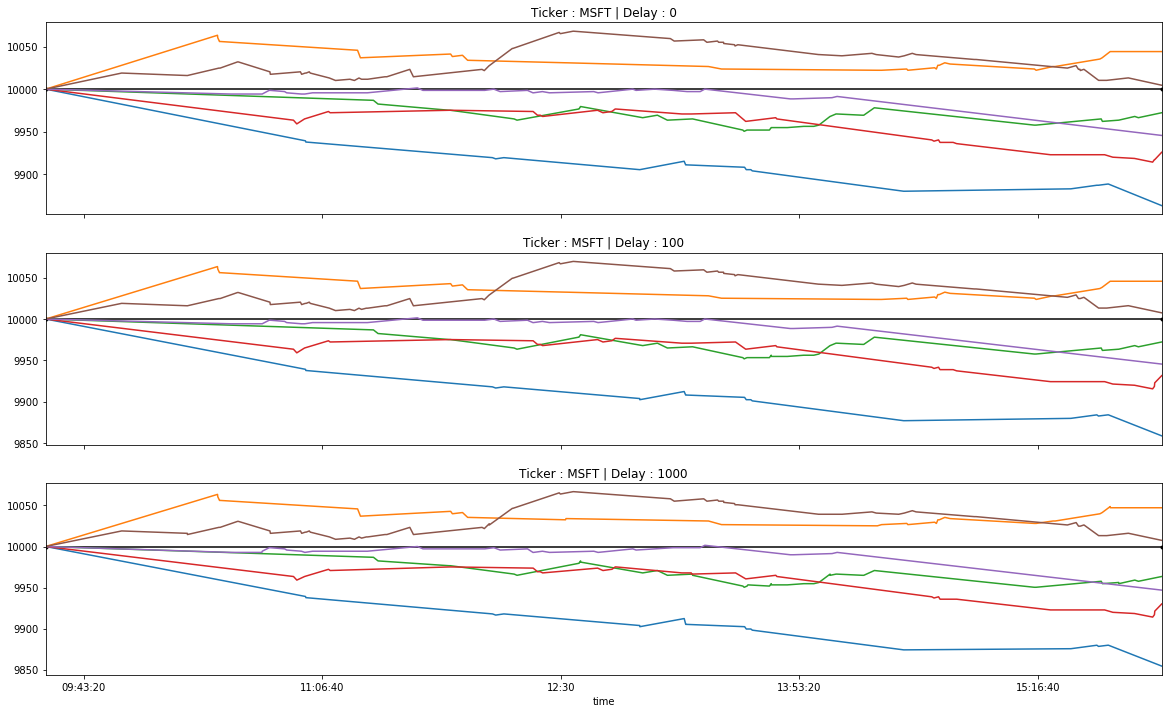

In [393]:
filenames = glob.glob('output/' + ticker + '_RSI_tradebook_*.csv')


fig, axs = plt.subplots(nrows=len(delays), ncols=1, figsize=(20,12), sharex=True)

for delay, ax in zip(delays, axs):
    ax.axhline(y=10000, c='black', marker='.')
    ax.set_title("Ticker : " + ticker + " | Delay : " + str(delay))

for file in filenames:
    tradebook = pd.read_csv(file, index_col=0)
    tradebook.index = pd.to_datetime(tradebook.index).time
    
    for delay, ax in zip(delays, axs.flatten()):
        series_balance = tradebook["OUTSTANDING_BALANCE_" + str(delay)]
        series_inventory = tradebook["OUTSTANDING_INVENTORY_" + str(delay)]
        series_balance = series_balance[series_inventory==0]
        series_balance.sort_index(ascending=True, inplace=True)
        series_balance.plot(ax=ax)
        
plt.xlim(series_balance.index[0], series_balance.index[-1])    
plt.show()   